This file runs locally（not available but with limited reference value）

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
#%cd /Desktop/XAI/XAI_1

In [5]:
#%env 

In [1]:
#%pip install tensorflow,matplotlib,tqdm

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import save_img

import numpy as np

import matplotlib.pyplot as plt

# Silence TQDM progress bar
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)



# Parameters in the code

In [6]:
param_img_size = (224,224)
param_batch_size = 1
# The data folder must contain one folder for each class
path_data = "./data_fer" 

## Initializes the dataset

In [7]:
# TODO Check label_mode is categorical as param
train_original_ds = image_dataset_from_directory(
        path_data,
        shuffle=False,
        
        seed=13,
        image_size=param_img_size,
        batch_size=param_batch_size,
    )

Found 1000 files belonging to 10 classes.


## Select the transformations to apply

In [15]:
#%pip install tensorflow_addons
#%pip install opencv-python

In [ ]:

for elem in train_original_ds:
  print(elem)

In [9]:
train_original_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
import tensorflow as tf
import tensorflow_addons as tfa
import cv2

contrast_factor = 2. # contrast_factor must be in the interval (-inf, inf).
def selected_transf(img):
  #img = tf.image.adjust_contrast(img, contrast_factor)
  img = tf.image.adjust_hue(
    img, 0.5)
  return img
  #x = tf.image.adjust_contrast(x, 1)

#f = lambda x: tf.image.adjust_contrast(x)

train_ds = (train_original_ds.map(
  lambda x, y: (selected_transf(x), y)))
# train1_ds.map(tf.image.adjust_contrast, 2.)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Example of images and their labels

Original image:

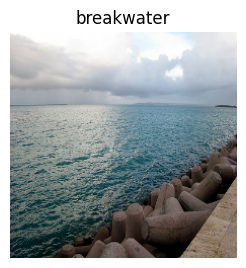

In [17]:
image_batch, label_batch = next(iter(train_original_ds))
class_names = train_original_ds.class_names
plt.figure(figsize=(10, 10))
for i in range(param_batch_size):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
image_batch[0]

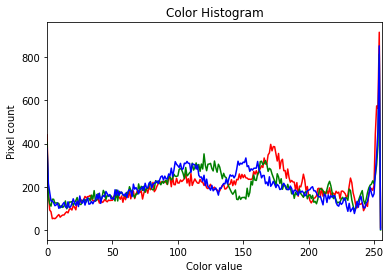

In [ ]:
color_hist(image_batch[0])

Transformed image:

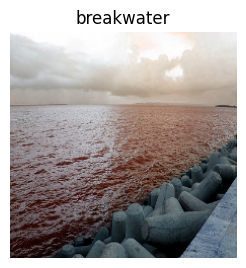

In [18]:
image_batch, label_batch = next(iter(train_ds))
class_names = train_original_ds.class_names
plt.figure(figsize=(10, 10))
for i in range(param_batch_size):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

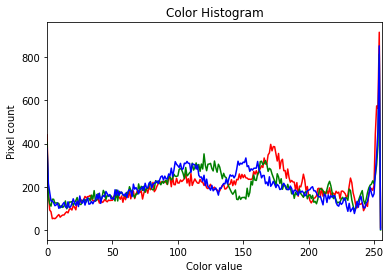

In [ ]:
color_hist(image_batch[0])

In [ ]:
def color_hist(image):  
  # tuple to select colors of each channel line
  colors = ("red", "green", "blue")

  # create the histogram plot, with three lines, one for
  # each color
  plt.figure()
  plt.xlim([0, 256])
  for channel_id, color in enumerate(colors):
      histogram, bin_edges = np.histogram(
          image[:, :, channel_id], bins=256, range=(0, 256)
      )
      plt.plot(bin_edges[0:-1], histogram, color=color)

  plt.title("Color Histogram")
  plt.xlabel("Color value")
  plt.ylabel("Pixel count")

# Helper: Dictionary from class name to id

In [20]:
import pandas as pd
df_classes = pd.read_csv('class_to_id.csv')
dict_classes = dict(zip(df_classes.name, df_classes.id))
class_names = train_original_ds.class_names

# dict_classes['guillotine']

# Instantiates the MobileNet architecture

In [21]:
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow.keras as keras

model = MobileNetV3Large(
    input_shape= (224,224,3),
    #alpha=1.0,
    minimalistic=False,
    #include_top=True,
    weights="imagenet",
    #input_tensor=None,
    classes=1000,
    #pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
) 

## Get predictions for the dataset

To prevent inactivity, press ctrl+shif+i, open the console and run this code.

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton, 60000);
```

In [22]:
## See the prediction
predictions = model.predict(train_ds)
# results = tf.keras.applications.mobilenet.decode_predictions(predictions)


1000/1000 [==============================] - 18s 17ms/step


In [ ]:
# to see the predicitons

#tf.keras.applications.mobilenet.decode_predictions(predictions)

In [23]:
# Path
paths_save = train_original_ds.file_paths

In [24]:
# Labels
labels_save = [class_names[labels.numpy()] for _, labels in train_ds.unbatch()]

In [ ]:
# Predictions
# pred_save = np.asarray(results)[:,:,1:]

In [25]:
# Predictions probabilities
pred_prob_save = np.zeros((len(paths_save)))
for i in range(len(paths_save)):
    id_label = dict_classes[labels_save[i]]
    pred_prob_save[i] = predictions[i][id_label]

In [26]:
np.save('data_pred/paths.npy', paths_save)
np.save('data_pred/labels.npy', labels_save)
np.save('data_pred/prediction_prob.npy', pred_prob_save)

### This functions evaluates the dataset but does not work right now

In [27]:
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['sparse_categorical_crossentropy'])

scores = model.evaluate(train_ds)

1000/1000 [==============================] - 19s 17ms/step - loss: 9.8226 - sparse_categorical_crossentropy: 9.8226


# Instantiates Lime Explainer

In [28]:
%pip install lime

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached scipy-1.9.3-cp38-cp38-win_amd64.whl (39.8 MB)
     ---------------------------------------- 8.2/8.2 MB 9.1 MB/s eta 0:00:00
     ---------------------------------------- 12.2/12.2 MB 9.9 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 8.3 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 8.3 MB/s eta 0:00:00
     -------------------------------------- 210.3/210.3 kB 6.5 MB/s eta 0:00:00
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=afdf712925a09edcb886366411ab288c3d655f448ef022b041185ae17193b687
  Stored in directory: c:\users\simpletree\appdata\local\p

In [35]:
from lime import lime_image
from tensorflow.keras.preprocessing import image
from skimage.segmentation import mark_boundaries
import tensorflow as tf

explainer = lime_image.LimeImageExplainer()


In [38]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [40]:
# New paths to save masked images, class folders need to be created
new_paths = [s.replace('data_fer','data_fer_masked') for s in paths_save]
# new_img_masked = np.empty((len(train_ds), 224,224,3), dtype=(np.int32))
counter = 0
size_img = param_img_size[0]*param_img_size[1]
l_mask_sizes = []
for img, label in train_ds:
    explanation = explainer.explain_instance(
    image.img_to_array(img[0]).astype('double'), 
    model.predict, 
    top_labels=10, 
    hide_color=0, 
    num_samples=500)

    id_label = dict_classes[class_names[label[0]]]

    if id_label in explanation.top_labels:
        temp, mask = explanation.get_image_and_mask(id_label, positive_only=True, num_features=5, hide_rest=False)
        new_img = mark_boundaries(temp, mask).astype(np.int32)

        # Get how big is the mask
        size_mask = np.count_nonzero(mask)/size_img
        
        # Add size of mask to list
        l_mask_sizes.append(size_mask)
        
        # Every image is 50176 in total

#         new_img_masked[counter]=new_img
#       Save every image
        tf.keras.utils.save_img(new_paths[counter], new_img)
        #new_img.save(new_paths[counter], new_img)

    counter+=1

a_mask_sizes = np.array(l_mask_sizes)
np.save('data_pred/mask_sizes.npy', a_mask_sizes)

1/1 [==============================] - 0s 157ms/step


ImportError: Could not import PIL.Image. The use of `array_to_img` requires PIL.

# Repeat predictions for masked dataset

In [ ]:
path_data_masked = './data_fer_masked/'
train_ds_masked = image_dataset_from_directory(
        path_data_masked,
        shuffle=False,
        
        seed=13,
        image_size=param_img_size,
        batch_size=param_batch_size,
    )

Found 708 files belonging to 10 classes.


In [ ]:
## See the prediction
predictions_masked = model.predict(train_ds_masked)
# results_masked = tf.keras.applications.mobilenet.decode_predictions(predictions_masked)


708/708 [==============================] - 137s 183ms/step


In [ ]:
# Path
paths_masked = train_ds_masked.file_paths
paths_masked_fixed = [w.replace('data_fer_masked','data_fer') for w in paths_masked]

mask_sizes = np.load('data_pred/mask_sizes.npy')

df_masked = pd.DataFrame({'path':paths_masked_fixed, 'mask_size':mask_sizes})

In [ ]:
#df_masked = pd.DataFrame({'path':paths_masked_fixed, 'mask_size':None})

In [ ]:
# Load original
paths_save = np.load('data_pred/paths.npy')
labels_save = np.load('data_pred/labels.npy')
pred_prob_save = np.load('data_pred/prediction_prob.npy')
df_original = pd.DataFrame({'path':paths_save,'label':labels_save, 'pred_original':pred_prob_save})

## Join original dataframe with masked dataframe

In [ ]:
df_joined = pd.concat([df_original.set_index('path'),df_masked.set_index('path')], axis=1, join='inner').reset_index()
df_joined['pred_masked'] = 0

### New column with predictions of their labels

In [ ]:
for i in range(len(df_joined)):
    id_label = dict_classes[df_joined['label'].iloc[i]]
    df_joined['pred_masked'].iloc[i] = predictions_masked[i][id_label]

AttributeError: ignored

In [ ]:
df_joined['impact_score'] = (df_joined['pred_original']-df_joined['pred_masked'])/df_joined['mask_size']

In [ ]:
df_joined

,path,label,pred_original,mask_size,pred_masked,impact_score
0,./data_fer/breakwater/1028059374_ae2f62913a.jpg,breakwater,0.958854,None,0,NaN
1,./data_fer/breakwater/103250350_79e782e4d5.jpg,breakwater,0.834753,None,0,NaN
2,./data_fer/breakwater/103481088_ab3153394a.jpg,breakwater,0.594284,None,0,NaN
3,./data_fer/breakwater/1105051185_137fae3470.jpg,breakwater,0.051740,None,0,NaN
4,./data_fer/breakwater/1105892994_28e48736f3.jpg,breakwater,0.612649,None,0,NaN
...,...,...,...,...,...,...
703,./data_fer/matchstick/197441556_13f32862af.jpg,matchstick,0.929199,None,0,NaN
704,./data_fer/matchstick/19787340_9cabf67a8e.jpg,matchstick,0.009523,None,0,NaN
705,./data_fer/matchstick/209620271_586a3e8fdc.jpg,matchstick,0.394709,None,0,NaN
706,./data_fer/matchstick/2098214627_2970a2a369.jpg,matchstick,0.045368,None,0,NaN


In [ ]:
df_joined.impact_score.mean()

nan